In [508]:
 %cd /sci/labs/yotamd/lab_share/avishai.wizel/eRNA/

/sci/labs/yotamd/lab_share/avishai.wizel/eRNA


/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [509]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from scipy.sparse import issparse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow import keras
import tensorflow_addons as tfa



# Load data

In [510]:
sc_rna = ad.read_h5ad('./10X_PBMC/03_filtered_data/filtered_rna_adata.h5ad')
sc_atac = ad.read_h5ad("./10X_PBMC/03_filtered_data/filtered_atac_adata.h5ad")

/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Main parameters

In [511]:
top_rna_var_genes = 10000
top_var_peaks = 500

# Filters cells

In [512]:
def filter_cells_by_qc_metrics(
    adata: ad.AnnData,
    min_genes: int = 200,
    max_genes: int = 2500,
    min_counts: int = 1000,
    max_mt_pct: float = 40.0
) -> ad.AnnData:
    """
    Filters cells based on standard quality control metrics:
    number of genes detected, total counts, and mitochondrial gene percentage.

    Args:
        adata (anndata.AnnData):
            The AnnData object containing raw gene expression counts (cells x genes).
            Assumes mitochondrial genes are prefixed with 'MT-' (human) or 'mt-' (mouse).
        min_genes (int): Minimum number of genes expressed per cell.
        max_genes (int): Maximum number of genes expressed per cell (to remove doublets).
        min_counts (int): Minimum total counts per cell.
        max_mt_pct (float): Maximum allowed percentage of mitochondrial counts per cell.

    Returns:
        anndata.AnnData: A new AnnData object with filtered cells.
                         QC metrics are added to adata.obs.
    """
    
    # Ensure adata.var['mt'] is set if not already
    if 'mt' not in adata.var:
        # Assuming human data with 'MT-' prefix. Adjust for mouse ('mt-') or other.
        adata.var['mt'] = adata.var_names.str.startswith('MT-') 

    print("Calculating QC metrics...")
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt'], 
        percent_top=None, 
        log1p=False, 
        inplace=True
    )

    print(f"Original number of cells: {adata.n_obs}")
    
    # Apply filters
    initial_cells_count = adata.n_obs
    
    # Combine filtering criteria using boolean logic
    cells_to_keep = (
        (adata.obs['n_genes_by_counts'] >= min_genes) &
        (adata.obs['n_genes_by_counts'] <= max_genes) &
        (adata.obs['total_counts'] >= min_counts) &
        (adata.obs['pct_counts_mt'] <= max_mt_pct)
    )
    
    adata_filtered = adata[cells_to_keep, :].copy()
    
    filtered_cells_count = adata_filtered.n_obs
    removed_cells_count = initial_cells_count - filtered_cells_count
    
    print(f"Cells removed: {removed_cells_count}")
    print(f"Number of cells after filtering: {filtered_cells_count}")

    return adata_filtered

In [513]:
adata_filtered_qc = filter_cells_by_qc_metrics(
    sc_rna.copy(),
    min_genes=200,
    max_genes=5000,
    min_counts=500,
    max_mt_pct=25
)

/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Calculating QC metrics...
Original number of cells: 11852
Cells removed: 172
Number of cells after filtering: 11680


/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Normalize scRNA-seq

In [514]:
# 1. Size Normalization
sc.pp.normalize_total(adata_filtered_qc, target_sum=1e4)

# 2. Log-transformation (log1p)
sc.pp.log1p(adata_filtered_qc)
sc.pp.highly_variable_genes(adata_filtered_qc, n_top_genes=top_rna_var_genes, flavor='seurat')


Take only high variable genes:

In [515]:
sc_rna_filtered = adata_filtered_qc[:, adata_filtered_qc.var.highly_variable].copy()

# filter atac cells based on filtered rna cells
filtered_cell_barcodes = sc_rna_filtered.obs_names
adata_atac_filtered = sc_atac[sc_atac.obs_names.isin(filtered_cell_barcodes), :].copy()
adata_atac_filtered = sc_atac[filtered_cell_barcodes, :].copy()



/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Filter for highly variable peaks

In [516]:
scRNA = sc_rna_filtered.X
scATAC_binary_all_peaks = adata_atac_filtered.X.toarray()

In [517]:
import numpy as np

# Y is the binary scATAC matrix of shape (num_cells, num_peaks)
# Each entry is 0 (closed) or 1 (open)
# Example: Y = np.array(...) shape (1000, 100000)

# Step 1: Compute the fraction of cells where each peak is open
open_fraction = np.mean(scATAC_binary_all_peaks, axis=0)  # shape: (num_peaks,)

# Step 2: Compute the variance of each peak (binary variance: p*(1-p))
variance = open_fraction * (1 - open_fraction)

# Step 3: Define thresholds for valid peaks
min_open_fraction = 0.05   # Only consider peaks open in at least 2% of cells
max_open_fraction = 0.7    # Avoid peaks that are always open

# Step 4: Apply filtering mask based on frequency
mask = (open_fraction >= min_open_fraction) & (open_fraction <= max_open_fraction)

# Step 5: Select top-k peaks by variance from the filtered peaks
top_k = 500  # number of peaks to select
filtered_variance = variance[mask]

# Get the indices of the top-k highest variance peaks from the filtered set
top_indices_in_filtered = np.argsort(filtered_variance)[-top_k:]

# Map those indices back to the original peak indices
selected_peaks = np.where(mask)[0][top_indices_in_filtered]

# Result: selected_peaks is an array of 500 peak indices (out of the original 100K)
# You can now subset your original matrix:

scATAC_binary = scATAC_binary_all_peaks[:, selected_peaks]

In [518]:
del(sc_rna)
del(sc_atac)
del(adata_atac_filtered)
del(sc_rna_filtered)

In [519]:
print("scRNA dim (cells X genes):" ,scRNA.shape)
print("scATAC dim (cells X peaks):" ,scATAC_binary.shape)

scRNA dim (cells X genes): (11680, 10000)
scATAC dim (cells X peaks): (11680, 500)


In [520]:
# Standardize the RNA-seq data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(scRNA.toarray())

In [521]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(scATAC_binary)

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [523]:
# # Calculate the total number of zeros and ones across all peaks combined
# # This flattens the array and then counts occurrences of 0s and 1s.
# num_zeros = np.sum(y_train == 0)
# num_ones = np.sum(y_train == 1)
# total_elements = num_zeros + num_ones # Total number of 0s and 1s combined in y_train

# # Calculate class weights
# # These weights are inversely proportional to the class frequencies.
# # This assigns a higher weight to the less frequent class (typically '1's in imbalanced data)
# # to make the model pay more attention to correctly classifying them.
# # The 'total_elements / 2.0' part ensures the sum of weights for a balanced dataset
# # would ideally be around 1, helping to stabilize the loss scale.

# # Ensure no division by zero if a class is completely absent (though rare for 0/1)
# weight_for_0 = (total_elements / (10.0 * num_zeros)) if num_zeros > 0 else 1.0
# weight_for_1 = (total_elements / (2.0 * num_ones)) if num_ones > 0 else 1.0

# # Store the calculated weights in a dictionary format required by Keras
# class_weights = {0: weight_for_0, 1: weight_for_1}
# print(f"Computed class weights: {class_weights}")


In [525]:

# --- 2 Building the Keras Neural Network Model ---

# Define model parameters
input_dim = X_train.shape[1]  # Number of genes (input features)
output_dim = y_train.shape[1] # Number of ATAC genomic locations (output targets)

# Build the Sequential Keras model
model = keras.Sequential([
    # Input Layer: Defines the shape of the input data
    layers.Input(shape=(input_dim,)),

    # Hidden Layers (Dense - Fully Connected)
    # Common to start with larger layers and gradually decrease units.
    # 'relu' (Rectified Linear Unit) is a common activation function for hidden layers.
    layers.Dense(units=128),
    layers.Activation("swish"),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2), # Dropout layer for regularization (prevents overfitting), dropping 20% of neurons
    layers.Dense(units=64),
    layers.Activation("swish"),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.Dense(units=32),
    layers.Activation("swish"),
    # layers.BatchNormalization(),

    # layers.BatchNormalization(),
    # You can add more layers here if needed

    # Output Layer
    # The number of units must match the number of ATAC locations (output_dim).
    # Activation function:
    # - 'linear' (or no activation) for continuous regression output (e.g., after StandardScaler).
    # - 'sigmoid' if your 'y' targets are scaled between 0 and 1 (e.g., after MinMaxScaler)
    #   or if they are binary (0/1) representing probabilities.
    
     layers.Dense(units=output_dim, activation=None) # sigmoid already in SigmoidFocalCrossEntropy
])


# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae', 'accuracy']) # Using MAE as an additional metric

# optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) # Start with 0.01 for LR
# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=150,
    decay_rate=0.9
)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

# optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7) # Start with 0.01 for LR

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=lr_schedule,  # אפשר גם 1e-4 אם המודל רועש
    rho=0.9,              # decay rate של ה־moving average
    momentum=0.0,         # אפשר לנסות גם 0.9
    centered=True        # אם True, משפר יציבות לפעמים
)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=1)
    union = tf.reduce_sum(y_true, axis=1) + tf.reduce_sum(y_pred, axis=1)
    
    dice_coef = (2. * intersection + smooth) / (union + smooth)
    loss = 1 - dice_coef
    
    return tf.reduce_mean(loss)

    
def combined_loss(y_true, y_pred):
    focal = tfa.losses.SigmoidFocalCrossEntropy(gamma=4.0, alpha=0.9)(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return focal + d_loss
    
# Compile the model
model.compile(
    optimizer=optimizer,  # Can lower to 1e-4 if data is noisy
    loss=combined_loss,
    metrics=[
        tf.keras.metrics.AUC(
            curve='PR',         # Precision-Recall AUC
            multi_label=True,   # Required for multi-label output
            num_labels=output_dim,  # Set to your output vector size
            name='pr_auc'
        ),
        tf.keras.metrics.Precision(name='precision'),      # How many predicted positives were correct
        tf.keras.metrics.Recall(name='recall')             # How many actual positives were found
    ]
)

# Print a summary of the model architecture
model.summary()


Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_419 (Dense)           (None, 128)               1280128   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_420 (Dense)           (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_421 (Dense)           (None, 32)                2080      
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dense_422 (Dense)           (None, 500)             

In [526]:

# --- 3. Training the Model ---
class LrPrinterCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        # אם lr הוא scheduler, צריך להעריך אותו ל-step הנוכחי:
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            # אפשר לקבל את step הנוכחי דרך self.model.optimizer.iterations
            step = self.model.optimizer.iterations.numpy()
            current_lr = lr(step).numpy()
        else:
            current_lr = lr.numpy()
        print(f"Epoch {epoch+1}: Learning rate is {current_lr:.6f}")


print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=50,          # Number of times to iterate over the entire training dataset
    batch_size=32,      # Number of samples per gradient update
    validation_split=0.1, # Fraction of the training data to be used as validation data
                          # This helps monitor performance on unseen data during training.
    verbose=1,           # Display progress bar during training
    callbacks=[LrPrinterCallback()]
    # class_weight=class_weights
)
print("Model training complete.")





Starting model training...
Epoch 1/50
263/263 [==============================] - 4s 12ms/step - loss: 63.8455 - pr_auc: 0.1129 - precision: 0.1160 - recall: 0.3547 - val_loss: 5.2971 - val_pr_auc: 0.1463 - val_precision: 0.1387 - val_recall: 0.4419
Epoch 2/50
263/263 [==============================] - 3s 11ms/step - loss: 6.2336 - pr_auc: 0.1648 - precision: 0.1550 - recall: 0.6077 - val_loss: 4.6649 - val_pr_auc: 0.1668 - val_precision: 0.1544 - val_recall: 0.5743
Epoch 3/50
263/263 [==============================] - 3s 10ms/step - loss: 4.8389 - pr_auc: 0.1971 - precision: 0.1729 - recall: 0.6854 - val_loss: 4.5056 - val_pr_auc: 0.1759 - val_precision: 0.1645 - val_recall: 0.6021
Epoch 4/50
263/263 [==============================] - 3s 11ms/step - loss: 4.3465 - pr_auc: 0.2176 - precision: 0.1841 - recall: 0.7147 - val_loss: 4.3695 - val_pr_auc: 0.1837 - val_precision: 0.1665 - val_recall: 0.6411
Epoch 5/50
263/263 [==============================] - 3s 11ms/step - loss: 4.5439 - pr_

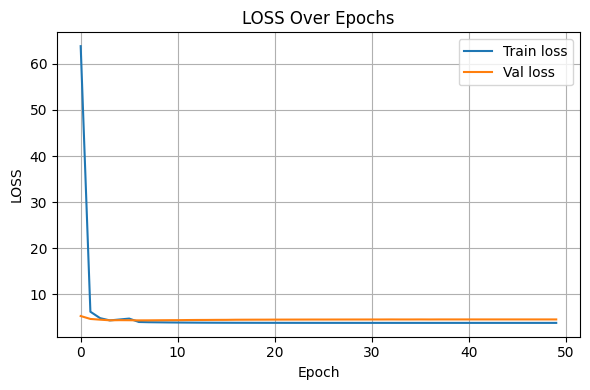

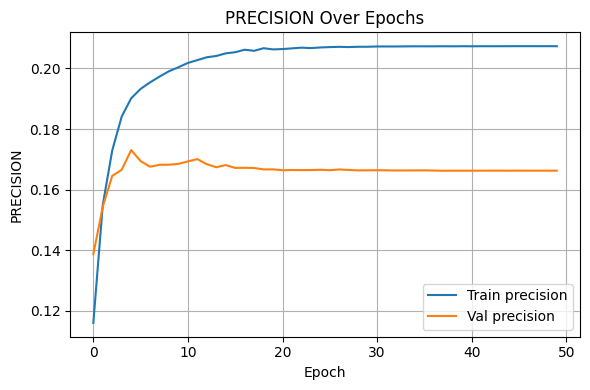

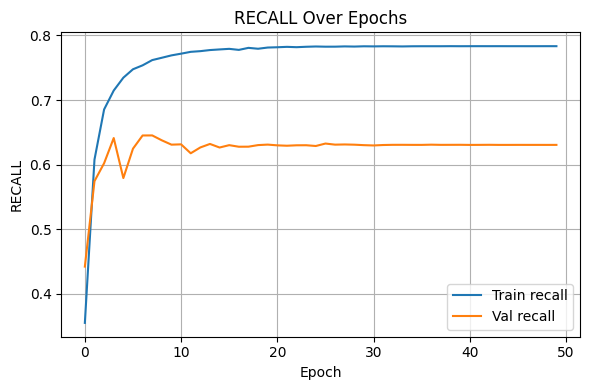

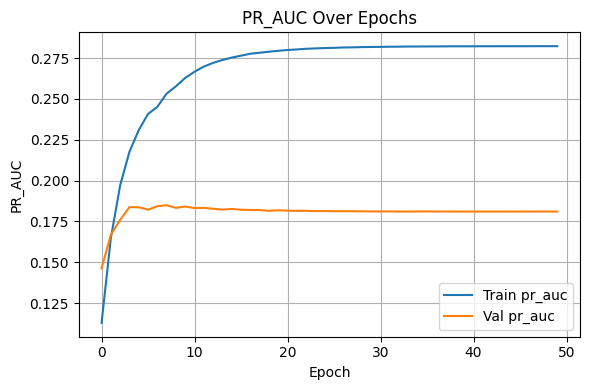

In [527]:
def plot_metrics_from_history(history):
    metrics = ['loss','precision', 'recall', 'pr_auc']
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
        plt.title(f"{metric.upper()} Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel(metric.upper())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_metrics_from_history(history)

In [528]:
y_pred_probs = tf.sigmoid(model.predict(X_test)).numpy() # no sigmoid in output

73/73 [==============================] - 0s 1ms/step


Mean Average Precision (mAP): 0.1808


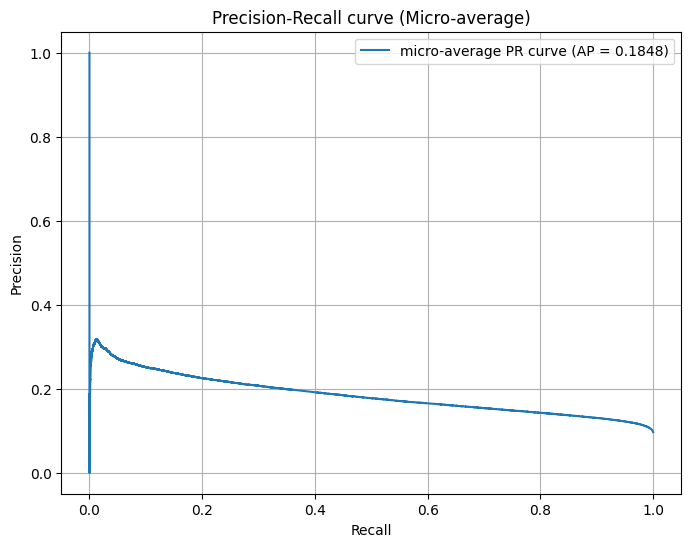

In [529]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precisions = []
recalls = []
average_precisions = []

for i in range(y_test.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_test[:, i], y_pred_probs[:, i])
    precisions.append(precision)
    recalls.append(recall)
    average_precisions.append(ap)

# ממוצע מדדי AP לכל הפיקים
mean_ap = np.mean(average_precisions)
print(f"Mean Average Precision (mAP): {mean_ap:.4f}")

# לצורך פלוט ממוצע – אופציה פשוטה היא להשתמש ב-micro-average PR curve:
from sklearn.metrics import precision_recall_curve

# Flatten arrays עבור micro-average
y_true_flat = y_test.ravel()
y_scores_flat = y_pred_probs.ravel()

precision_micro, recall_micro, _ = precision_recall_curve(y_true_flat, y_scores_flat)
average_precision_micro = average_precision_score(y_true_flat, y_scores_flat)

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f'micro-average PR curve (AP = {average_precision_micro:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (Micro-average)')
plt.legend()
plt.grid(True)
plt.show()

In [532]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Flatten if necessary (assuming multilabel binary format)
y_true_flat = y_test.ravel()
y_pred_flat = y_pred_probs.ravel()

# Get precision-recall-threshold values
precision, recall, thresholds = precision_recall_curve(y_true_flat, y_pred_flat)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Find the threshold that gives the best F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")


Best threshold: 0.6261
Precision: 0.1776, Recall: 0.4991, F1: 0.2620


In [533]:
y_pred_binary = (y_pred_probs >= best_threshold).astype(int)


In [535]:
# מספר ה-1ים בכל אחד
num_ones_pred = np.sum(y_pred_binary)
num_ones_true = np.sum(y_test)

# כמה 1ים מופיעים גם בפרדיקציה וגם בלייבל (True Positives)
num_true_positives = np.sum((y_pred_binary == 1) & (y_test == 1))

print(f"Number of 1s in prediction: {num_ones_pred}")
print(f"Number of 1s in ground truth: {num_ones_true}")
print(f"Number of matching 1s (True Positives): {num_true_positives}")


Number of 1s in prediction: 317121
Number of 1s in ground truth: 112867.0
Number of matching 1s (True Positives): 56335


In [536]:
from scipy.stats import fisher_exact
import numpy as np

# Flatten to 1D if needed
y_true = y_test.ravel()
y_pred = y_pred_binary.ravel()

# Calculate the four cells of the contingency table
TP = np.sum((y_pred == 1) & (y_true == 1))
FP = np.sum((y_pred == 1) & (y_true == 0))
FN = np.sum((y_pred == 0) & (y_true == 1))
TN = np.sum((y_pred == 0) & (y_true == 0))

# Create the contingency table
table = [[TP, FP],
         [FN, TN]]

# Perform Fisher's Exact Test
odds_ratio, p_value = fisher_exact(table)

# Print results
print("Contingency Table:", table)
print("Fisher's Exact Test p-value:", p_value)
print("Odds ratio:", odds_ratio)


Contingency Table: [[56335, 260786], [56532, 794347]]
Fisher's Exact Test p-value: 0.0
Odds ratio: 3.0353581009101536
